# Results

In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.insert(0, '../../..')

We will use GPU with identifier "1", after agreeing with other users with access to the same machine.

In [2]:
from os import environ

environ["CUDA_VISIBLE_DEVICES"]="1"

## 1. Load model and data

Let us load some data from the validation set

In [3]:
from os import listdir

# Paths where data is stored
dataset_dir = '/root/fs9/lucas/data/datasets/year_256/'
chunk_filenames = listdir(dataset_dir)
valid_chunk_filenames = chunk_filenames[27:35]

In [4]:
from pyphoon.app.utils import load_h5datachunks

X_valid, Y_valid, idx_valid, seqno_valid = load_h5datachunks(dataset_dir,
                                                             valid_chunk_filenames, 
                                                             features=['data', 'pressure', 'idx', 'seq_no'],
                                                             ignore_classes=[6, 7],
                                                             verbose=True
                                                            )

Using TensorFlow backend.
/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


 file chunk_27.h5 read
 file chunk_28.h5 read
 file chunk_29.h5 read
 file chunk_30.h5 read
 file chunk_31.h5 read
 file chunk_32.h5 read
 file chunk_33.h5 read
 file chunk_34.h5 read


Next, we load the model by using module `pyphoon.models.tc_pressure_regression`, which provides the network architecture and corresponding data preprocessor.

In [6]:
from pyphoon.models.tc_pressure_regression import tcRegNet, tcRegPreprocessor

model = tcRegNet('../weights.hdf5')
preprocessor = tcRegPreprocessor()

## 2. Kernels first layer
An interesting thing to observe are the kernel weights in the first layer. These kernels are in charge of scanning the input images and detecting certain patterns. Ideally, all kernels should show distinct features. Appearance of similar kernels may indicate that we are using too many kernels. Also, kernels with near-zero values may indicate dead units, a phenomenon that often happens when using ReLU activation.

In [7]:
# Get all weights
weights = {}
for layer in model.layers:
    weights[layer.name] = layer.get_weights()

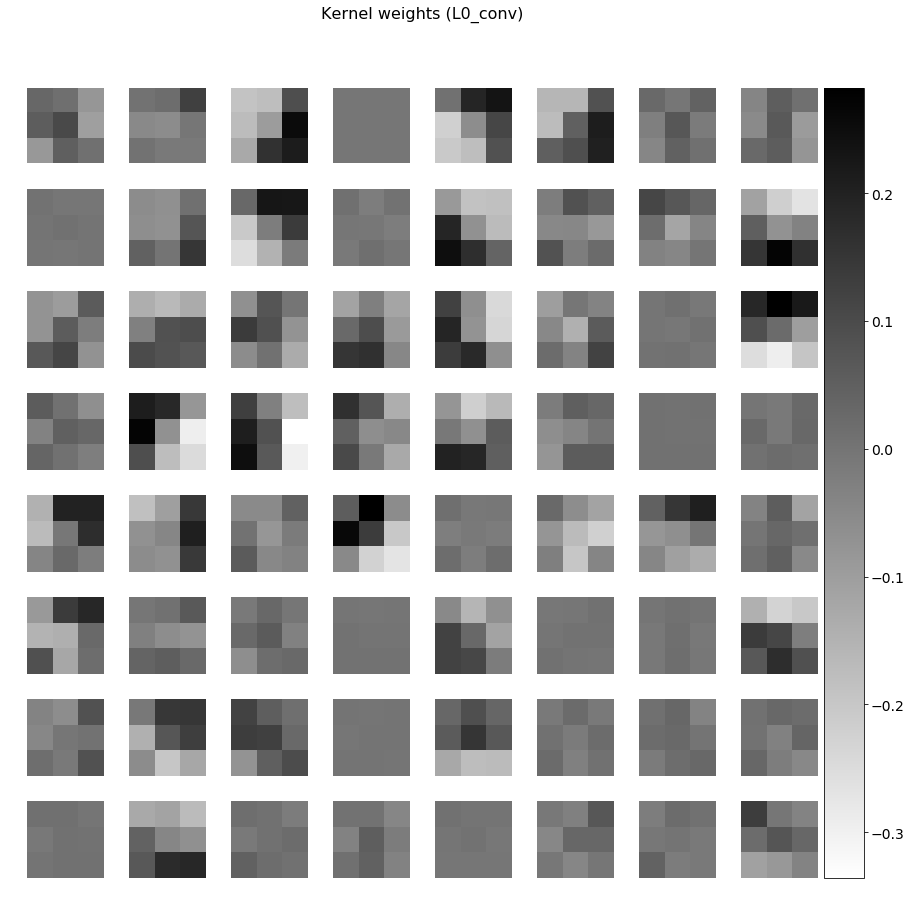

In [9]:
from pyphoon.app.explore import good_shape_conv_weights
from pyphoon.visualise import nice_imshow, make_mosaic
import matplotlib.cm as cm
import matplotlib.pyplot as plt

W = good_shape_conv_weights(weights['conv2d_1'])
plt.figure(figsize=(15, 15))
plt.title('Kernel weights (L0_conv)', fontsize=16, y=1.08)
plt.axis('off')
nice_imshow(plt.gca(), make_mosaic(W[:,:,:,0], 8, 8), cmap=cm.binary, colorbar=True, barsize=14)
#plt.savefig('weights_tcreg.eps', format='eps')
plt.show()

## 2. Network activations
An artificial neural network may be regarded as a black box. To mitigate this feeling, in this section we look at the activation maps throughout the different network layers for a particular input image. We will use an image from sequence `200003`, which depicts a tropical cyclone of intensity 5.

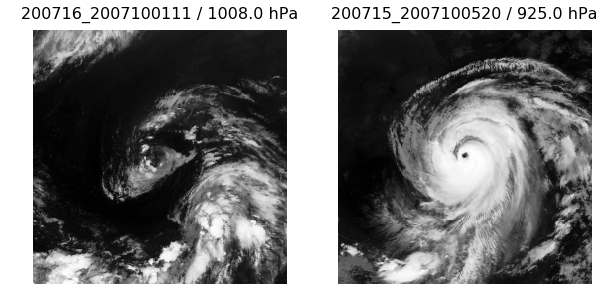

In [10]:
from pyphoon.io.h5 import read_source_image
from os.path import join
import numpy as np
import matplotlib.pyplot as plt

chunk = 2
idx = 185
X1 = X_valid[chunk][idx]
title1 = idx_valid[chunk][idx].decode("utf-8") + " / " + str(Y_valid[chunk][idx]) + " hPa"

chunk = 2
idx = 110
X2 = X_valid[chunk][idx]
title2 = idx_valid[chunk][idx].decode("utf-8") + " / " + str(Y_valid[chunk][idx]) + " hPa"

# Plot
plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.imshow(X1, 'Greys')
plt.axis('off')
plt.title(title1, fontsize=16, y=1.02)
plt.subplot(1,2,2)
plt.imshow(X2, 'Greys')
plt.axis('off')
plt.title(title2, fontsize=16, y=1.02)
#plt.savefig("regtc_example_imgs.eps", format='eps')
plt.show()

In [11]:
import cv2

def prepare_image(X):
    # Resize image to 256x256 and add axis 0 (required for preprocessor)
    X = np.expand_dims(cv2.resize(X, (256,256)), 0)
    # Preprocess
    X = preprocessor.apply(X)
    # Crop
    X = X[:, 64:64+128, 64:64+128, :]
    
    return X

X1 = prepare_image(X1)
X2 = prepare_image(X2)

### 2.1 Convolutional Layers
Let us commence with the visualisation of the feature maps in the first three layers, which are convolutional.

In [12]:
from pyphoon.app.explore import get_activations

def plot_conv_layers(X, name="X", save=False):
    C = get_activations(model, 'max_pooling2d_1', X)
    plt.figure(figsize=(15, 15))
    plt.title('Feature maps after L0_mp', fontsize=36, y=1.02)
    plt.axis('off')
    nice_imshow(plt.gca(), make_mosaic(C, 8, 8), vmin=-1, vmax=7.5, colorbar=True, barsize=20)
    plt.savefig(name+'_L0.eps', format='eps') if save else 0

    C = get_activations(model, 'max_pooling2d_2', X)
    plt.figure(figsize=(15, 15))
    plt.title('Feature maps after L1_mp', fontsize=36, y=1.02)
    plt.axis('off')
    nice_imshow(plt.gca(), make_mosaic(C, 12, 12), vmin=-1, vmax=7.5, colorbar=True, barsize=20)
    plt.savefig(name+'_L1.eps', format='eps') if save else 0

    C = get_activations(model, 'max_pooling2d_3', X)
    plt.figure(figsize=(15, 15))
    plt.title('Feature maps after L2_mp', fontsize=36, y=1.02)
    plt.axis('off')
    nice_imshow(plt.gca(), make_mosaic(C, 12, 12), vmin=-1, vmax=7.5, colorbar=True, barsize=20)
    plt.savefig(name+'_L2.eps', format='eps') if save else 0

    C = get_activations(model, 'max_pooling2d_4', X)
    plt.figure(figsize=(15, 15))
    plt.title('Feature maps after L3_mp', fontsize=36, y=1.02)
    plt.axis('off')
    nice_imshow(plt.gca(), make_mosaic(C, 16, 16), vmin=-1, vmax=7.5, colorbar=True, barsize=20)
    plt.savefig(name+'_L3.eps', format='eps') if save else 0

    C = get_activations(model, 'max_pooling2d_5', X)
    plt.figure(figsize=(15, 15))
    plt.title('Feature maps after L4_mp', fontsize=36, y=1.02)
    plt.axis('off')
    nice_imshow(plt.gca(), make_mosaic(C, 16, 16), vmin=-1, vmax=7.5, colorbar=True, barsize=20)
    plt.savefig(name+'_L4.eps', format='eps') if save else 0

/usr/local/lib/python3.6/dist-packages/matplotlib/image.py:388: RuntimeWarning: invalid value encountered in subtract
  A_scaled -= a_min


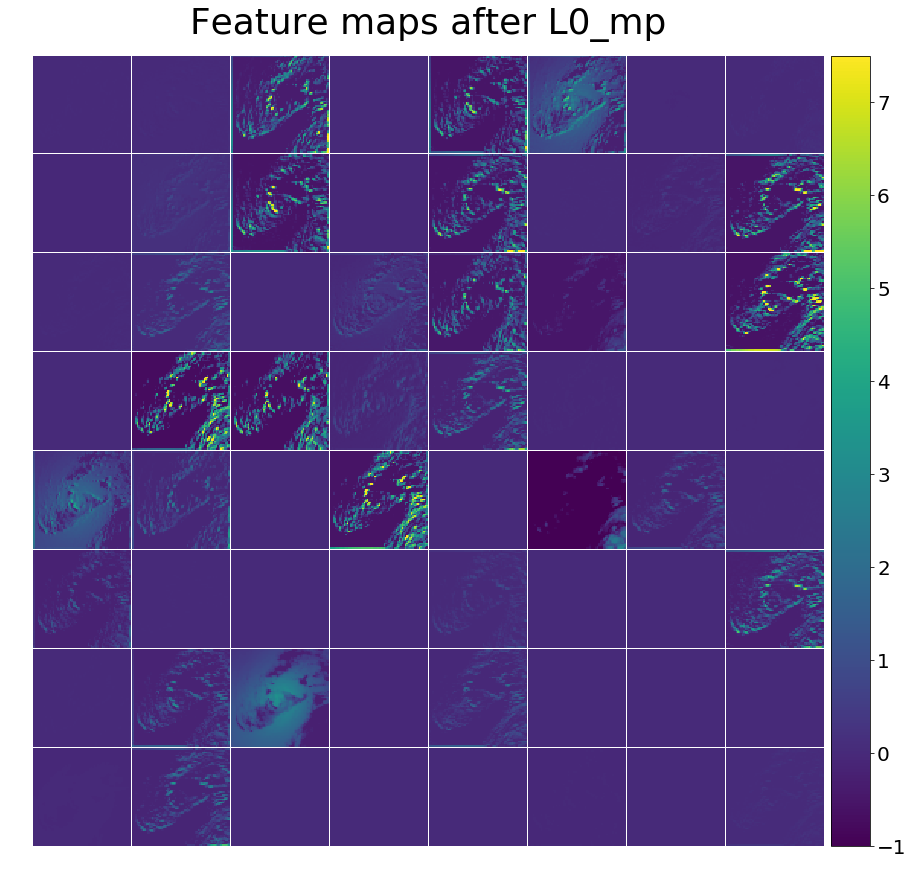

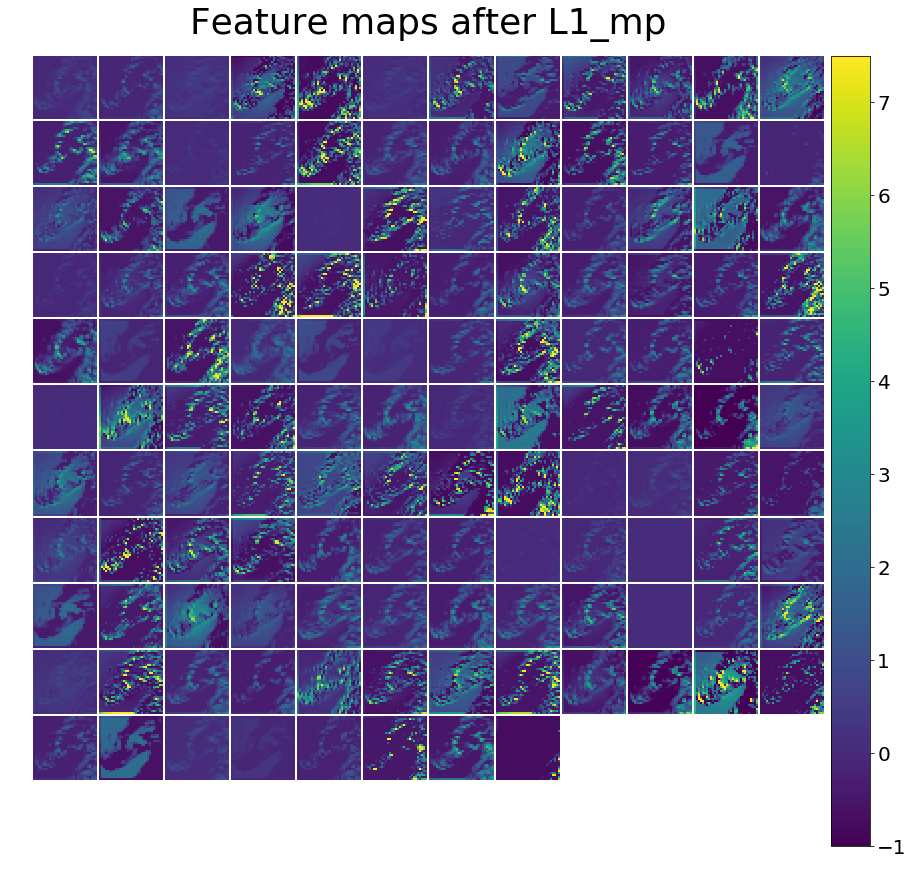

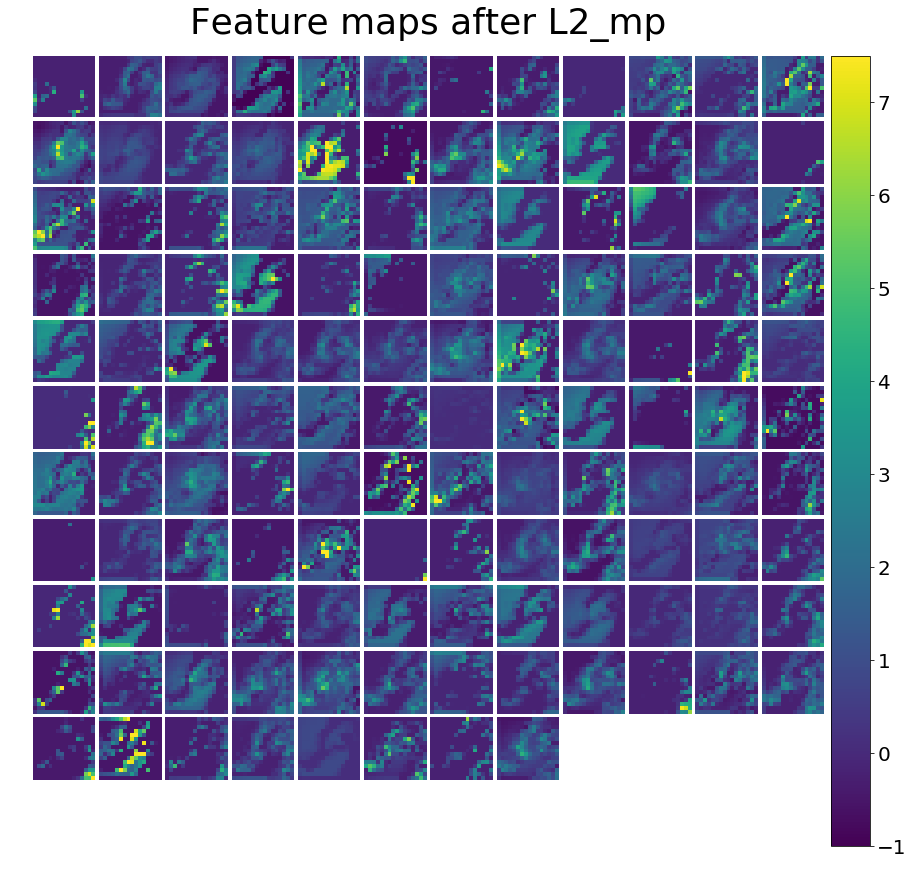

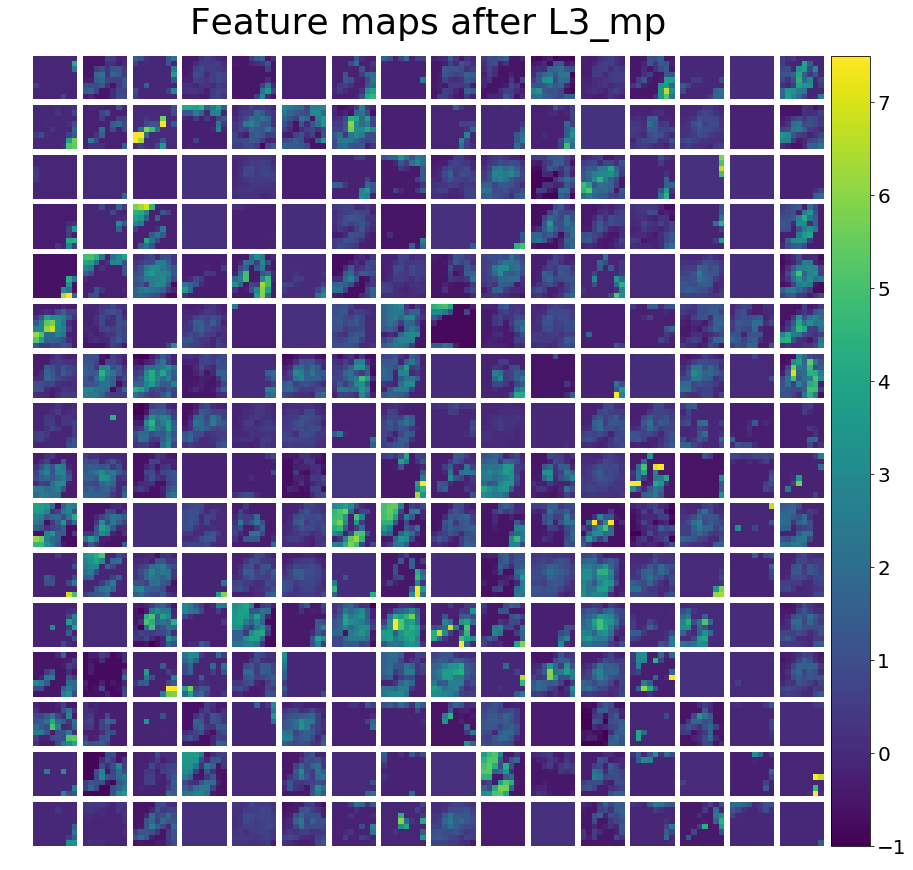

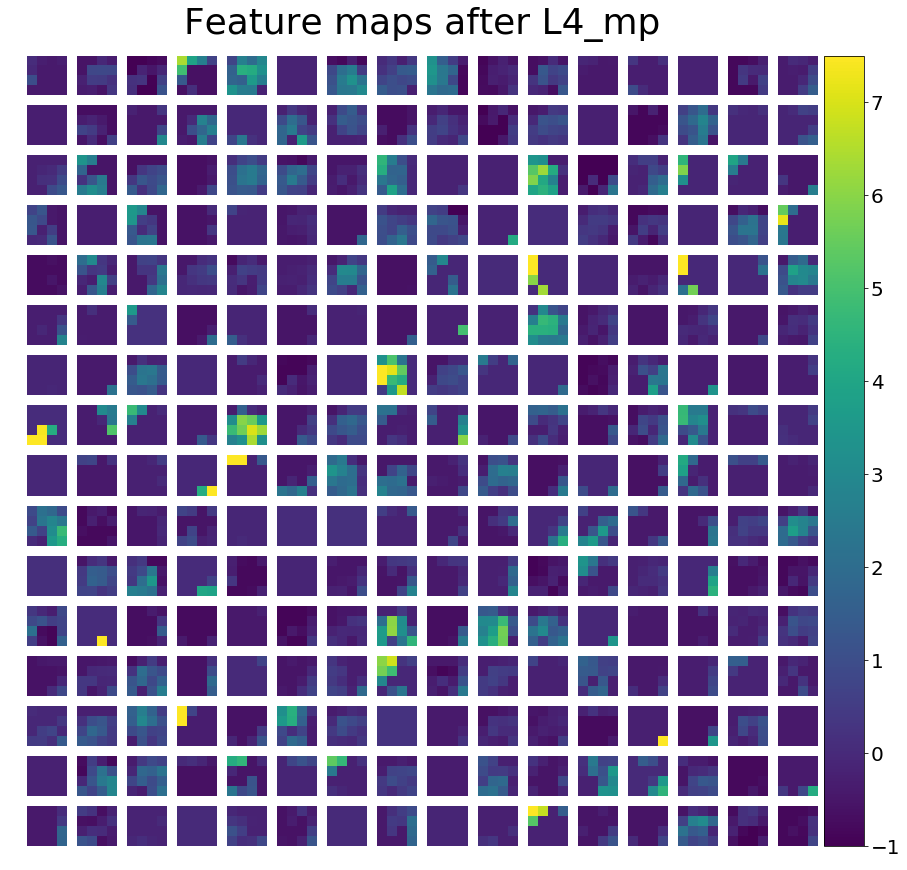

In [13]:
plot_conv_layers(X1, name="low_p", save=True)

/usr/local/lib/python3.6/dist-packages/matplotlib/image.py:388: RuntimeWarning: invalid value encountered in subtract
  A_scaled -= a_min


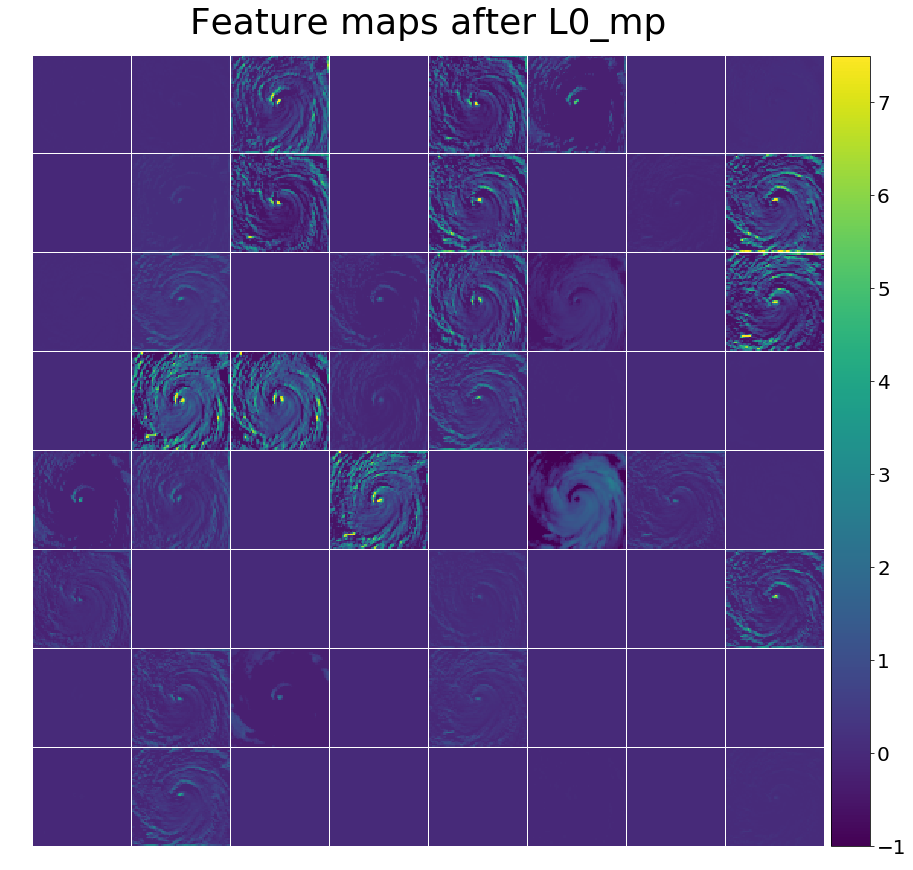

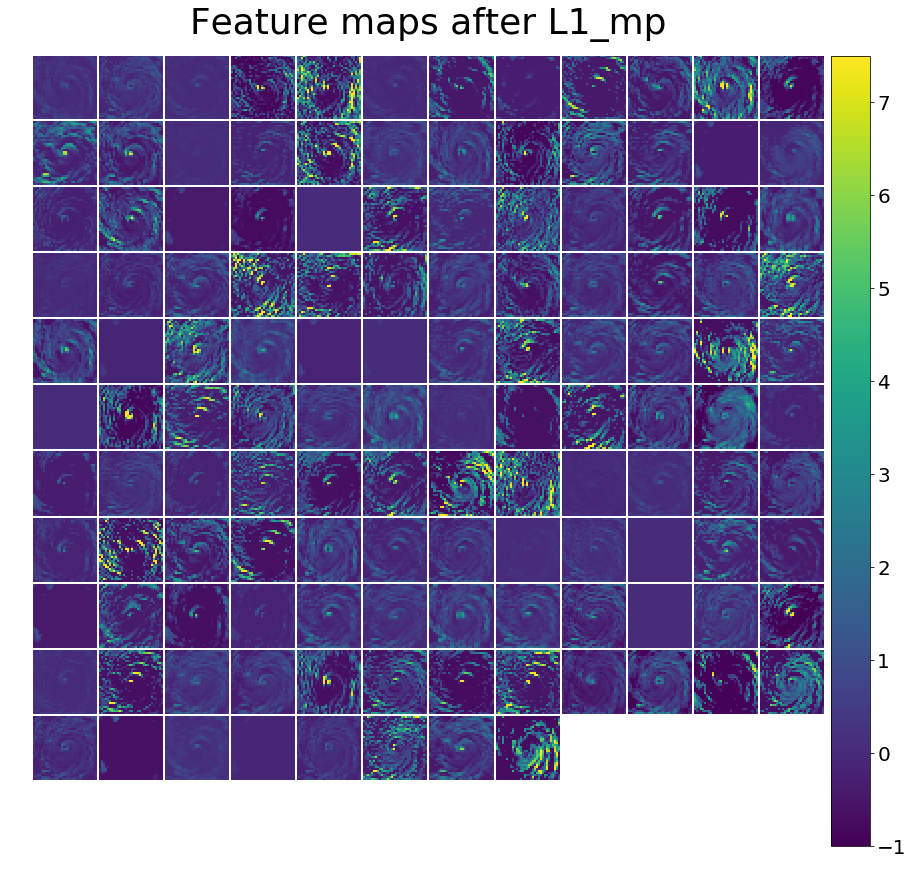

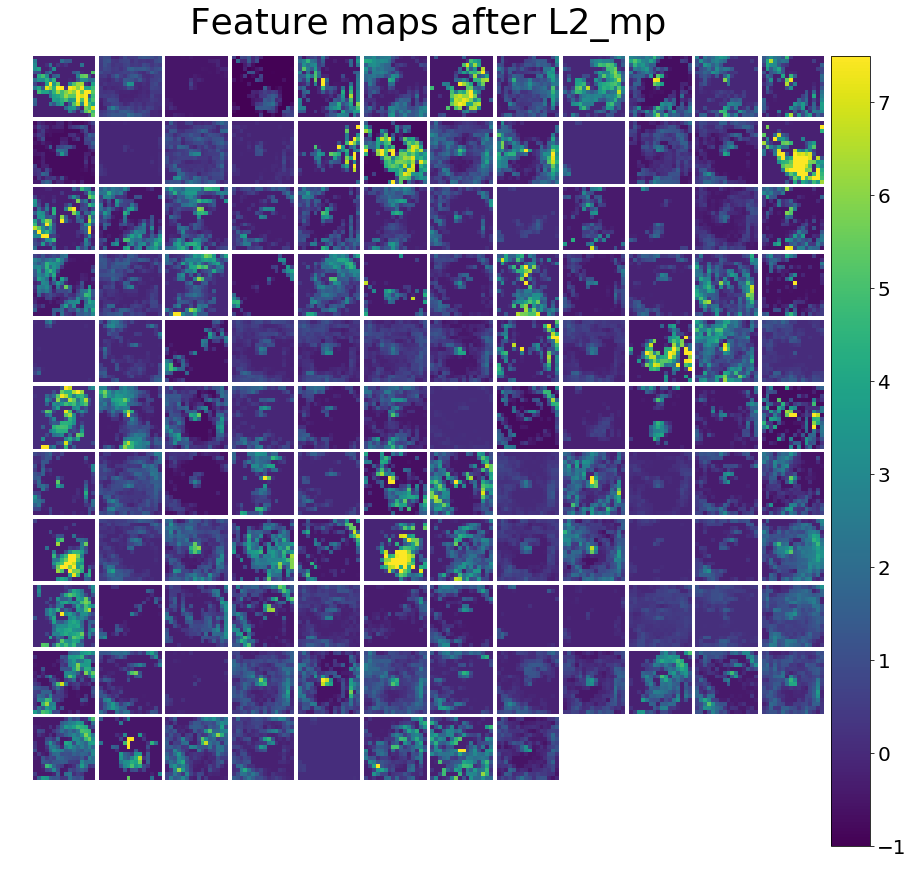

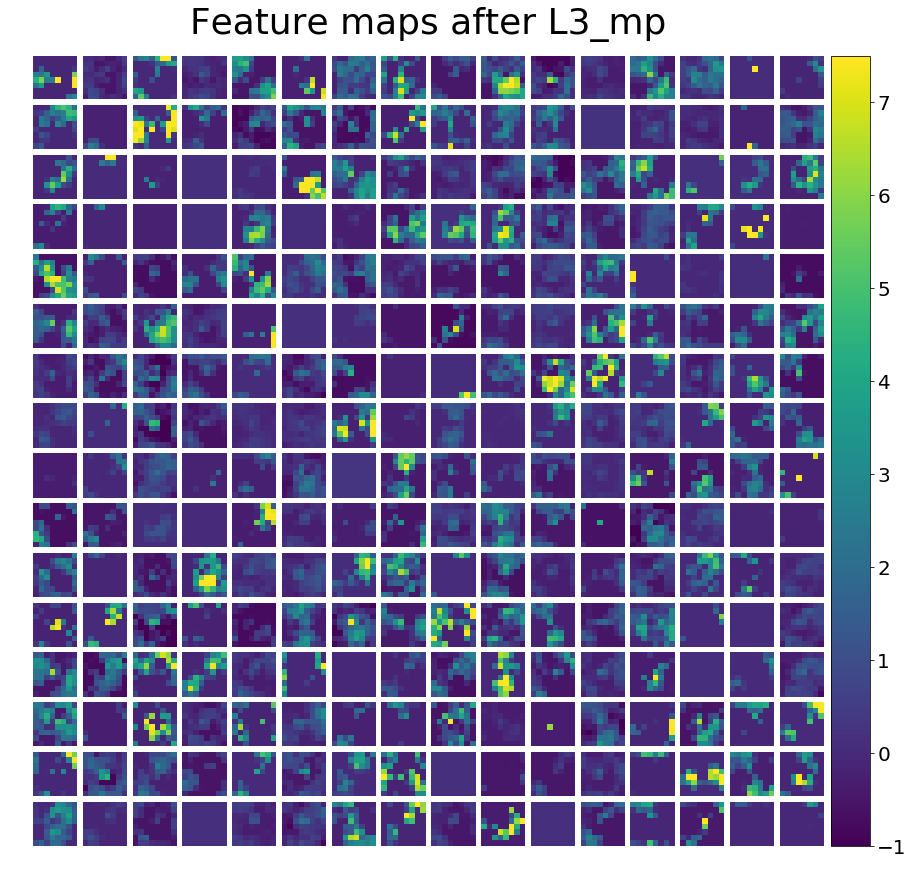

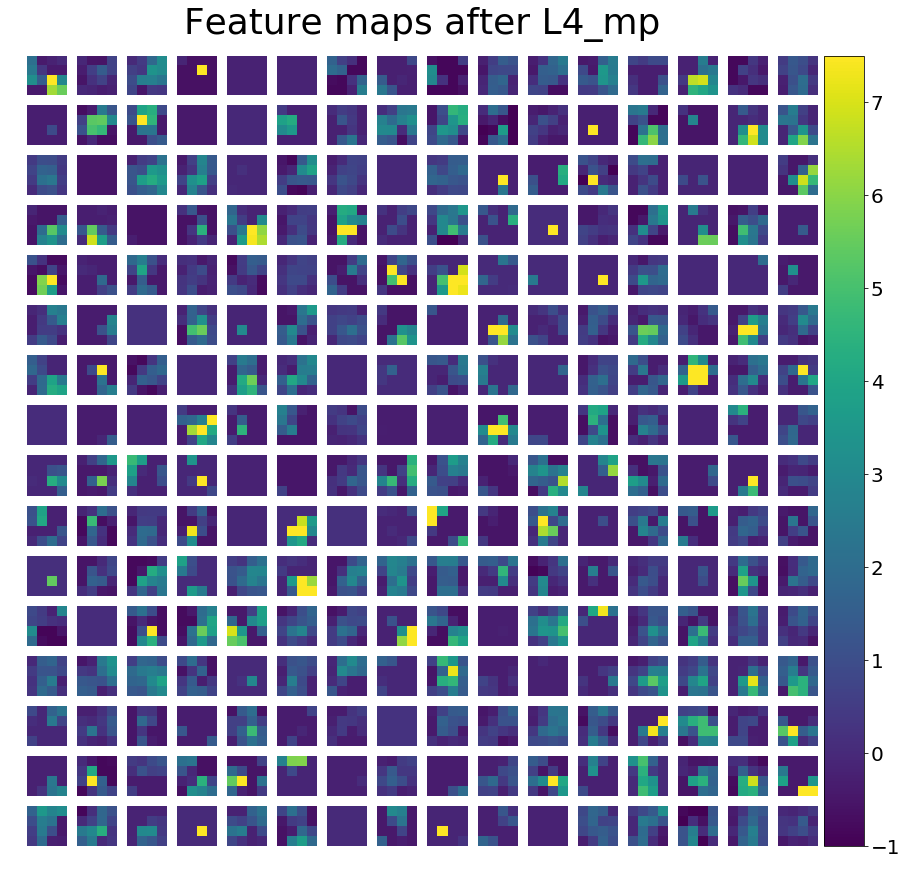

In [14]:
plot_conv_layers(X2, name="high_p", save=True)

### 2.2 Dense layer
Once the conv layers have been explored, we now proceed to inspect the dense layers. To this end, we will try to see which units are activated in the dense layers.

In [15]:
def plot_dense_layers(X):
    C = get_activations(model, 'batch_normalisation_6', X, dense=True, expand=100)
    plt.gcf().clear()
    im = plt.imshow(C)
    plt.colorbar(im)
    plt.axis('off')
    plt.title('Activations after BN_6', fontsize=10, y=1.02)
    # plt.savefig('../_assets/example_activation_l3_tc.eps', format='eps')
    plt.show()

    C = get_activations(model, 'batch_normalisation_7', X, dense=True, expand=20)
    plt.gcf().clear()
    im = plt.imshow(C)
    plt.axis('off')
    plt.colorbar(im)
    plt.title('Activations after BN_7', fontsize=10, y=1.02)
    # plt.savefig('../_assets/example_activation_l4_tc.eps', format='eps')
    plt.show()

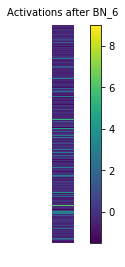

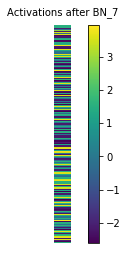

In [16]:
plot_dense_layers(X1)

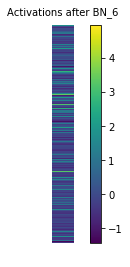

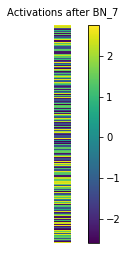

In [17]:
plot_dense_layers(X2)

## 2. Embedding
Here, we explore the possibility of using the last layers of TCRegNet as an embedding for other tasks. To this end, we use techniques such as PCA or LDA to project the data in low dimensional spaces so as to be able to observe its distribution.

We will be using the data from the validation set. Therefore, let us start by loading it and preprocess it accordingly.

In [18]:
X_valid_prep = [preprocessor.apply(x) for x in X_valid]
X_valid_prep = np.concatenate(X_valid_prep)[:, 64:64+128, 64:64+128, :]

In addition, we obtain the labels as a single array by concatenating the list of arrays.

In [55]:
y = np.concatenate(Y_valid)[:18000]

Next, we obtain the activations at the last layer. Note that we feed the model with batches of 500 samples, as otherwise they would not fit in memory.

In [42]:
n_samples = X_valid_prep.shape[0]
y_emb = []
for i in range(0,n_samples//500):
    y_emb.append(get_activations(model, 'batch_normalisation_7', X_valid_prep[i*500:i*500+500], dense=True).T)
y_emb = np.concatenate(y_emb)

To ease visualisation, we discretise the pressure values in 7 major groups: 880-899, 900-919, 920-939, 940-959, 960-975, 976-985, 986-1005 and 1005-end. Below we assign colors to these classes and illustrate it.

In [132]:
# colors
available_colors = ['b', 'c', 'g', 'y', 'tab:orange', 'r', 'm', 'k']
pressure_th = [1005, 985, 975, 959, 939, 919, 899, 880]
n_classes = len(available_colors)
colors = []
for yy in y:
    for p, c in zip(pressure_th, available_colors):
        if yy>p:
            colors.append(c)
            break

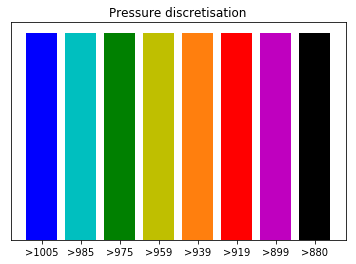

In [133]:
plt.bar(np.arange(n_classes), [1]*n_classes, color=available_colors)
plt.xticks(np.arange(n_classes), [">"+str(p) for p in pressure_th])
plt.yticks([], [])
plt.title("Pressure discretisation")
plt.show()

### 2.1 PCA
Let us start with PCA. PCA finds a basis which retains the maximum variation of the data and projects the data onto this new space. We use a space of equal dimension of the input space, i.e. 256. This is only to observe the relevance of each space. At the end, we will only work with way fewer number of dimensions.

In [144]:
from sklearn.decomposition import PCA

pca = PCA(n_components=256)
pca.fit(y_emb)
x_pca = pca.transform(y_emb)

To get an overview of the relevance of each component of the new basis, let us plot the cummulative variance ratio. The variance ratio measures the percentage of variance explained by each of the selected components. As we can see below, the first three components account for nearly 96% of all the variance. Hence we can basically focus on these in the following.

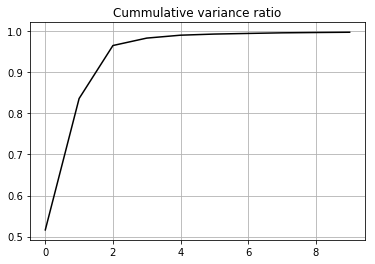

In [201]:
plt.plot(np.cumsum(pca.explained_variance_ratio_[:10]), c='k')
plt.title("Cummulative variance ratio")
plt.grid()
#plt.savefig("cum_pca.eps", format='eps')
plt.show()

Time to plot the data!

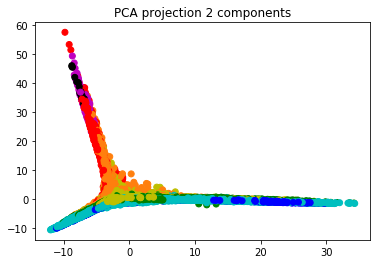

In [145]:
plt.scatter(x_pca[:, 0], x_pca[:, 1], c=colors)
plt.title("PCA projection 2 components")
plt.show()

Same but in 3D

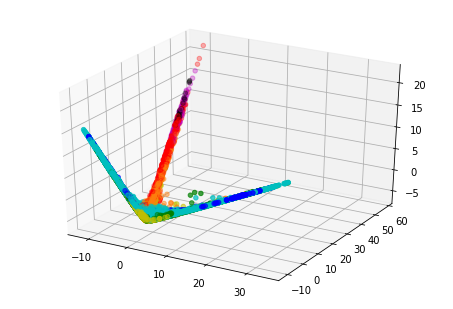

In [137]:
from mpl_toolkits.mplot3d import Axes3D

%matplotlib inline
fig = plt.figure()
axes = Axes3D(fig)
axes.scatter(xs=x_pca[:, 0], ys=x_pca[:, 1], zs=x_pca[:, 2], c=colors)

Let us further visualise the data by plotting the pca components along the pressure values. This way we can detect if there is any pattern as pressure increases or decreases.

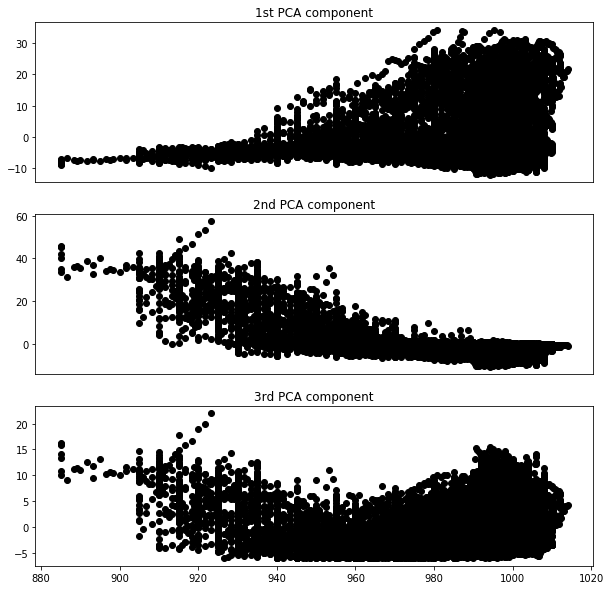

In [199]:
plt.figure(figsize=(10,10))
plt.subplot(3,1,1)
plt.scatter(y, x_pca[:, 0], c='k')#, c=colors)
plt.xticks([],[])
plt.title("1st PCA component")
plt.subplot(3,1,2)
plt.scatter(y, x_pca[:, 1], c='k')#, c=colors)
plt.xticks([],[])
plt.title("2nd PCA component")
plt.subplot(3,1,3)
plt.scatter(y, x_pca[:, 2], c='k')#, c=colors)
plt.title("3rd PCA component")
#plt.savefig("pca_3comp_press.eps", format='eps')
plt.show()

### 2.2 LDA
Well, time to check same but with LDA. LDA finds the basis that (i) maximizes inter-class variability and (ii) minimizes intra-class variability. That is, in this new basis, samples from different classes should be different while samples within the same class should be very close to each other.

First, we proceed to obtain the transformation of the input data.

In [202]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

clf = LinearDiscriminantAnalysis()
clf.fit(y_emb, colors)
x_lda = clf.transform(y_emb)

Plotting the first two components of the LDA space we observe that not only are the different classes placed in different regions but they are arranged in order from lowest to highest pressure values. This looks great.

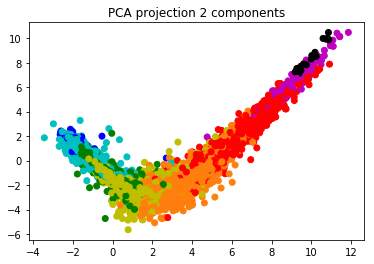

In [203]:
plt.scatter(x_lda[:, 0], x_lda[:, 1], c=colors)
plt.title("PCA projection 2 components")
#plt.savefig("lda.eps", format='eps')
plt.show()

If we now do as in PCA and observe the first 3 components along the pressure values we observe some sort of continuity in the data. Again, pressure magnitude order seems to be preserved.

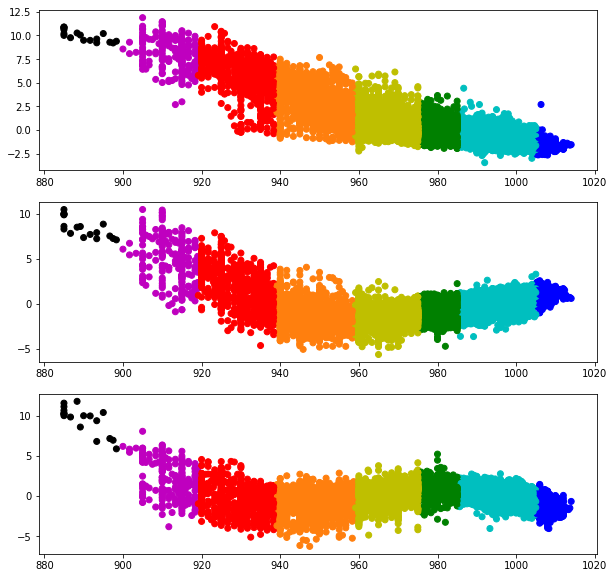

In [183]:
plt.figure(figsize=(10,10))
plt.subplot(3,1,1)
plt.scatter(y, x_lda[:, 0], c=colors)
plt.subplot(3,1,2)
plt.scatter(y, x_lda[:, 1], c=colors)
plt.subplot(3,1,3)
plt.scatter(y, x_lda[:, 2], c=colors)
plt.show()